# 데이터 불러오기

In [1]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.3.1

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 31.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.3.1 which is incompatible.


In [2]:
# 나눔폰트 설치
# 코드 실행 후 런타임 재시작
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (6,083 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126209 files and dire

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

from imblearn.over_sampling import SMOTE

# 경고 메시지 무시 설정
warnings.filterwarnings('ignore')


In [2]:
# 데이터 로드
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_csv('/content/drive/MyDrive/ESAA/OB/project1/train.csv')
test = pd.read_csv('/content/drive/MyDrive/ESAA/OB/project1/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/ESAA/OB/project1/sample_submission.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      2452 non-null   object 
 1   매물확인방식  2452 non-null   object 
 2   보증금     2452 non-null   float64
 3   월세      2452 non-null   int64  
 4   전용면적    1665 non-null   float64
 5   해당층     2223 non-null   float64
 6   총층      2436 non-null   float64
 7   방향      2452 non-null   object 
 8   방수      2436 non-null   float64
 9   욕실수     2434 non-null   float64
 10  주차가능여부  2452 non-null   object 
 11  총주차대수   1756 non-null   float64
 12  관리비     2452 non-null   int64  
 13  중개사무소   2452 non-null   object 
 14  제공플랫폼   2452 non-null   object 
 15  게재일     2452 non-null   object 
 16  허위매물여부  2452 non-null   int64  
dtypes: float64(7), int64(3), object(7)
memory usage: 325.8+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613 entries, 0 to 612
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      613 non-null    object 
 1   매물확인방식  613 non-null    object 
 2   보증금     613 non-null    float64
 3   월세      613 non-null    int64  
 4   전용면적    429 non-null    float64
 5   해당층     563 non-null    float64
 6   총층      611 non-null    float64
 7   방향      613 non-null    object 
 8   방수      611 non-null    float64
 9   욕실수     611 non-null    float64
 10  주차가능여부  613 non-null    object 
 11  총주차대수   438 non-null    float64
 12  관리비     613 non-null    int64  
 13  중개사무소   613 non-null    object 
 14  제공플랫폼   613 non-null    object 
 15  게재일     613 non-null    object 
dtypes: float64(7), int64(2), object(7)
memory usage: 76.8+ KB


전처리

# 선경

## 주차가능여부 (Categorical)
- 데이터 타입: 범주형 (가능 / 불가능)
- 처리 방법:
결측치가 있으면 "불가능"으로 처리 (일반적으로 주차 여부가 명확하지 않으면 불가능으로 간주)
값이 가능 또는 불가능 외의 데이터가 있으면 "불가능"으로 변환

## 총주차대수 (Numeric)
데이터 타입: 연속형 숫자 (0 이상)
문제점: 결측치 존재
처리 방법:
결측치를 0으로 대체 (주차 대수가 명확하지 않다면 주차 공간 없음으로 가정)
총주차대수 < 0인 경우 0으로 변경

In [6]:
train.loc[train['총주차대수'].isna(), '주차가능여부'].value_counts()

,count
주차가능여부,
불가능,585
가능,111


In [7]:
# 결측치 중 주차가 불가능한 값 → 0으로 대체
train.loc[(train["총주차대수"].isnull()) & (train['주차가능여부']=='불가능'), '총주차대수'] = 0

# 결측치 중 주차가 가능한 값 → (주차 가능한 값들의) 평균으로 대체
parking_mean = train.loc[train['주차가능여부']=='가능','총주차대수'].mean()
train['총주차대수'].fillna(parking_mean, inplace=True)

# 처리 후 결과 확인
print(train["총주차대수"].describe())

count    2452.000000
mean       15.535628
std        25.988625
min         0.000000
25%         1.000000
50%         6.000000
75%        21.525755
max       590.000000
Name: 총주차대수, dtype: float64


In [8]:
# test 데이터에 적용
test.loc[(test["총주차대수"].isnull()) & (test['주차가능여부']=='불가능'), '총주차대수'] = 0

# 결측치 중 주차가 가능한 값 → (주차 가능한 값들의) 평균으로 대체
parking_mean = test.loc[test['주차가능여부']=='가능','총주차대수'].mean()
test['총주차대수'].fillna(parking_mean, inplace=True)

# 처리 후 결과 확인
print(test["총주차대수"].describe())

count    613.000000
mean      15.411040
std       21.197192
min        0.000000
25%        1.000000
50%        6.000000
75%       23.000000
max      169.000000
Name: 총주차대수, dtype: float64


## 관리비 (Numeric)
데이터 타입: 연속형 숫자 (0 이상)
처리 방법:
관리비가 명확하지 않다면 0으로 대체
관리비가 음수이면 0으로 변경 (관리비는 음수가 될 수 없음)
평균값 또는 중앙값으로 대체 가능 (선택 사항)

In [9]:
# '관리비' 결측치 확인
print("결측치 개수 (관리비):", train["관리비"].isnull().sum())

# 결측치(NaN) → 0으로 대체
train["관리비"] = train["관리비"].fillna(0)

# 음수 값이 있다면 0으로 변환
train["관리비"] = train["관리비"].apply(lambda x: 0 if x < 0 else x)

# 처리 후 결과 확인
print(train["관리비"].describe())

결측치 개수 (관리비): 0
count    2452.000000
mean        5.477977
std         5.631185
min         0.000000
25%         0.000000
50%         5.000000
75%         9.000000
max        96.000000
Name: 관리비, dtype: float64


In [10]:
# '관리비' 결측치 확인
print("결측치 개수 (관리비):", test["관리비"].isnull().sum())

# 결측치(NaN) → 0으로 대체
test["관리비"] = test["관리비"].fillna(0)

# 음수 값이 있다면 0으로 변환
test["관리비"] = test["관리비"].apply(lambda x: 0 if x < 0 else x)

# 처리 후 결과 확인
print(test["관리비"].describe())

결측치 개수 (관리비): 0
count    613.000000
mean       5.435563
std        5.221359
min        0.000000
25%        0.000000
50%        5.000000
75%        9.000000
max       23.000000
Name: 관리비, dtype: float64


**최종 결론**
- "주차가능여부" → 결측치는 "불가능"으로 처리
 -  애초에 결측치 X

- "총주차대수" → 결측치는 0, 음수 값도 0으로 변환

- "관리비" → 결측치는 0, 음수 값도 0으로 변환
 - 애초에 결측치 X

# 휘민

## 매물확인방식

In [11]:
display(train['매물확인방식'].value_counts())
display(test['매물확인방식'].value_counts())

,count
매물확인방식,
현장확인,1705
전화확인,382
서류확인,365


,count
매물확인방식,
현장확인,444
서류확인,91
전화확인,78


In [12]:
# 범주별 비율 확인
display(train['매물확인방식'].value_counts()/train.shape[0])
display(test['매물확인방식'].value_counts()/test.shape[0])

,count
매물확인방식,
현장확인,0.695351
전화확인,0.155791
서류확인,0.148858


,count
매물확인방식,
현장확인,0.724307
서류확인,0.148450
전화확인,0.127243


## 보증금

In [13]:
print(train['보증금'].isnull().sum(), test['보증금'].isnull().sum())

0 0


Text(0.5, 1.0, 'test set 보증금 분포')

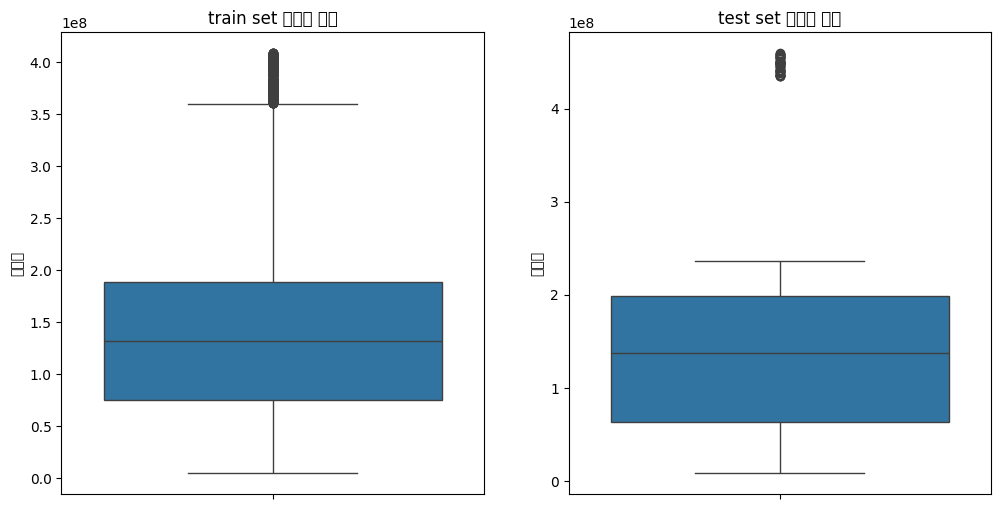

In [14]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

sns.boxplot(train['보증금'], ax=ax[0])
ax[0].set_title('train set 보증금 분포')

sns.boxplot(test['보증금'], ax=ax[1])
ax[1].set_title('test set 보증금 분포')

Text(0.5, 1.0, 'test set 보증금 분포')

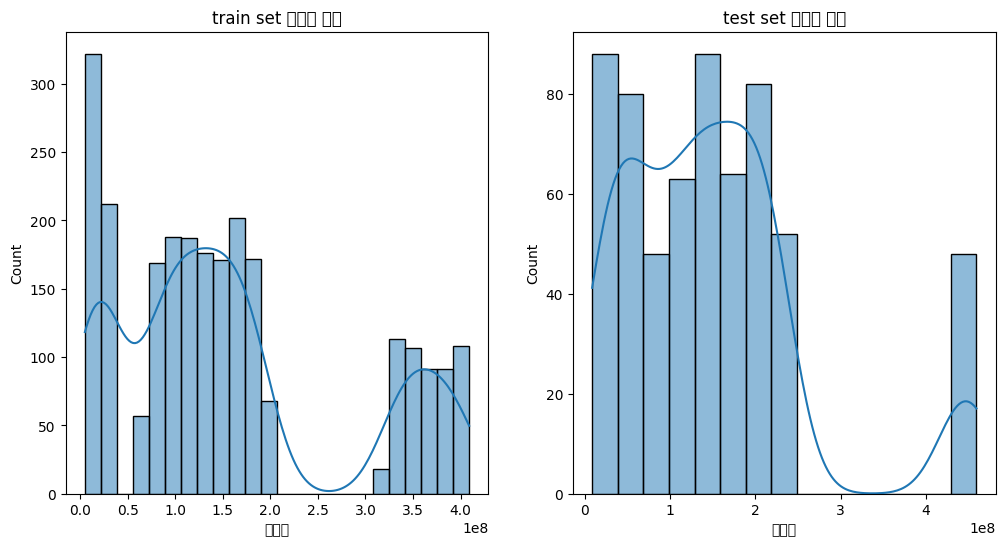

In [15]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

sns.histplot(train['보증금'], ax=ax[0], kde=True)
ax[0].set_title('train set 보증금 분포')

sns.histplot(test['보증금'], ax=ax[1], kde=True)
ax[1].set_title('test set 보증금 분포')

<Axes: ylabel='보증금'>

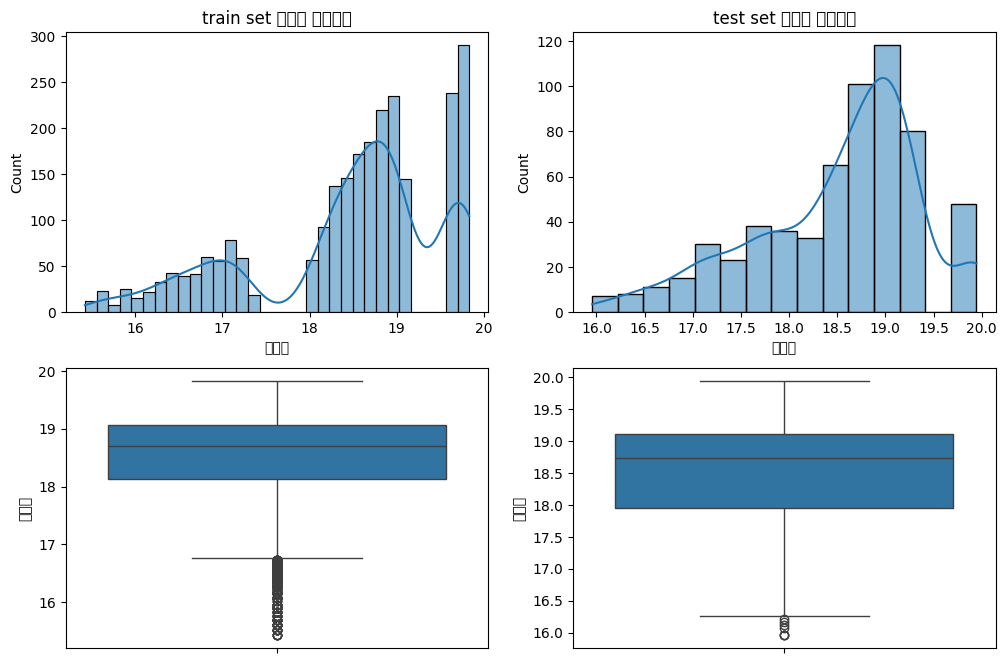

In [16]:
fig, ax = plt.subplots(2,2,figsize=(12,8))

sns.histplot(np.log1p(train['보증금']), ax=ax[0][0], kde=True)
ax[0][0].set_title('train set 보증금 로그분포')

sns.histplot(np.log1p(test['보증금']), ax=ax[0][1], kde=True)
ax[0][1].set_title('test set 보증금 로그분포')

sns.boxplot(np.log1p(train['보증금']), ax=ax[1][0])

sns.boxplot(np.log1p(test['보증금']), ax=ax[1][1])

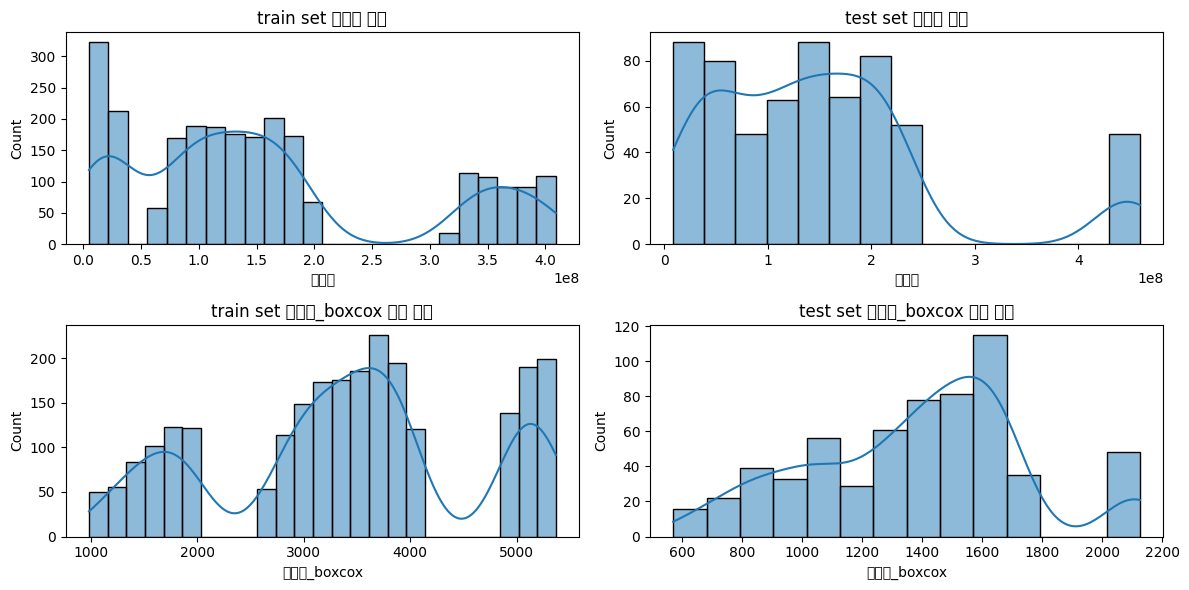

In [17]:
# 박스콕스 변환
from scipy.stats import boxcox

# Box-Cox 변환을 적용하는 함수
def apply_boxcox(df, column):
    # '월세' 피처가 음수일 수 있으므로 1을 더해줍니다
    df[column + '_boxcox'], lam = boxcox(df[column] + 1)  # 1을 더해 0 이하의 값 방지
    return lam

# train, test 데이터셋에 대해 Box-Cox 변환 적용
train_lam = apply_boxcox(train, '보증금')
test_lam = apply_boxcox(test, '보증금')

# 시각화 - 2x2 형태로 박스플롯과 히스토그램 출력
fig, ax = plt.subplots(2, 2, figsize=(12, 6))

# 히스토그램: train set 월세 분포
sns.histplot(train['보증금'], ax=ax[0][0], kde=True)
ax[0][0].set_title('train set 보증금 분포')

# 히스토그램: test set 월세 분포
sns.histplot(test['보증금'], ax=ax[0][1], kde=True)
ax[0][1].set_title('test set 보증금 분포')

# Box-Cox 변환 후 히스토그램: train set
sns.histplot(train['보증금_boxcox'], ax=ax[1][0], kde=True)
ax[1][0].set_title('train set 보증금_boxcox 변환 분포')

# Box-Cox 변환 후 히스토그램: test set
sns.histplot(test['보증금_boxcox'], ax=ax[1][1], kde=True)
ax[1][1].set_title('test set 보증금_boxcox 변환 분포')

# 그래프 표시
plt.tight_layout()
plt.show()

범주화 하는 것이 낫다고 판단

## 월세

In [18]:
print(train['월세'].isnull().sum(), test['월세'].isnull().sum())

0 0


Text(0.5, 1.0, 'test set 월세 분포')

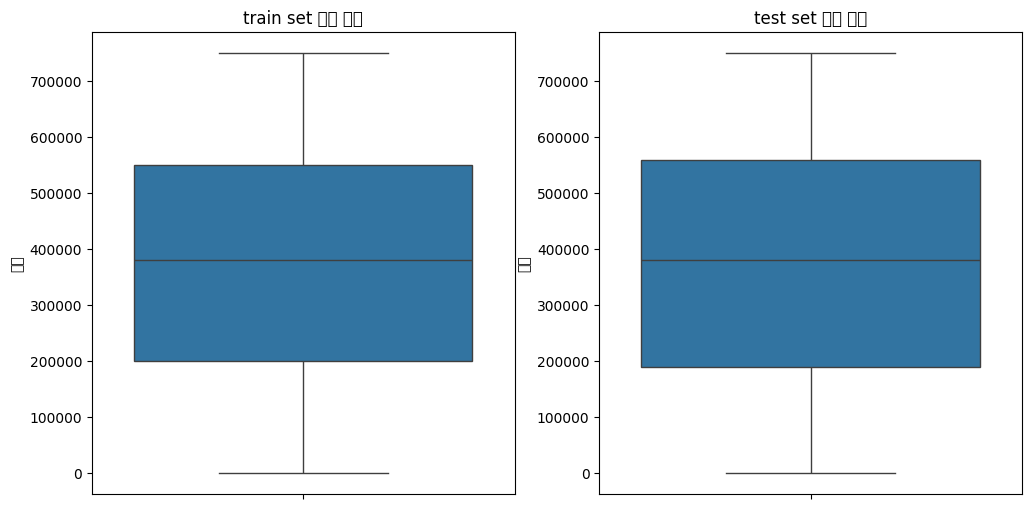

In [19]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

sns.boxplot(train['월세'], ax=ax[0])
ax[0].set_title('train set 월세 분포')

sns.boxplot(test['월세'], ax=ax[1])
ax[1].set_title('test set 월세 분포')

<Axes: xlabel='월세', ylabel='Count'>

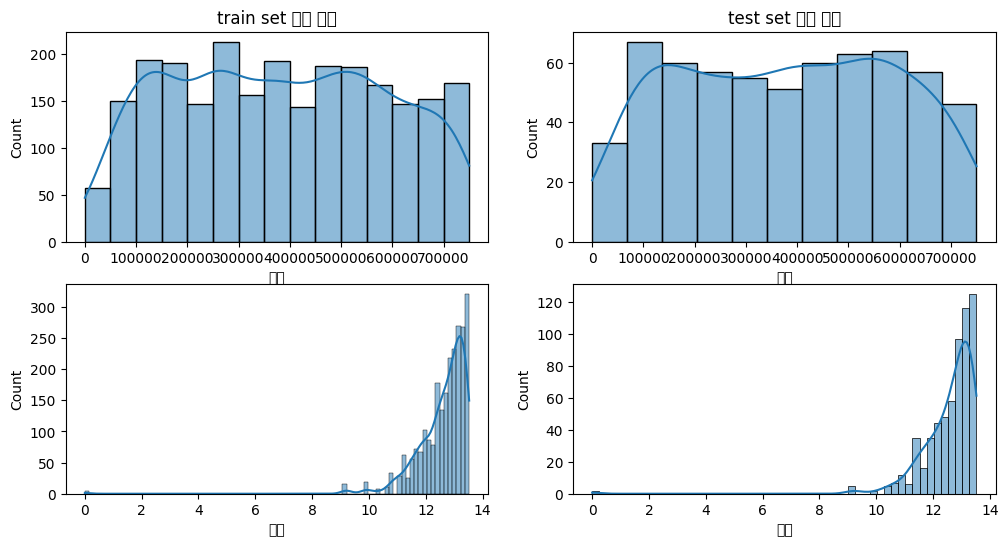

In [20]:
fig, ax = plt.subplots(2,2,figsize=(12,6))

sns.histplot(train['월세'], ax=ax[0][0], kde=True)
ax[0][0].set_title('train set 월세 분포')

sns.histplot(test['월세'], ax=ax[0][1], kde=True)
ax[0][1].set_title('test set 월세 분포')

sns.histplot(np.log1p(train['월세']), ax=ax[1][0], kde=True)

sns.histplot(np.log1p(test['월세']), ax=ax[1][1], kde=True)

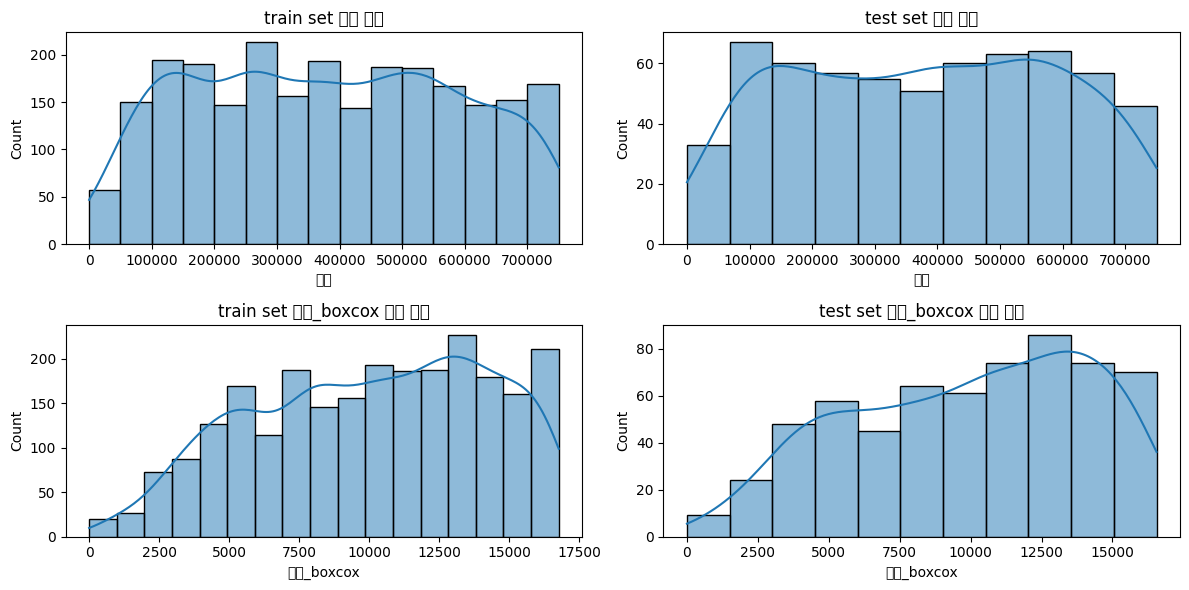

In [21]:
# 박스콕스 변환
from scipy.stats import boxcox

# Box-Cox 변환을 적용하는 함수
def apply_boxcox(df, column):
    # '월세' 피처가 음수일 수 있으므로 1을 더해줍니다
    df[column + '_boxcox'], lam = boxcox(df[column] + 1)  # 1을 더해 0 이하의 값 방지
    return lam

# train, test 데이터셋에 대해 Box-Cox 변환 적용
train_lam = apply_boxcox(train, '월세')
test_lam = apply_boxcox(test, '월세')

# 시각화 - 2x2 형태로 박스플롯과 히스토그램 출력
fig, ax = plt.subplots(2, 2, figsize=(12, 6))

# 히스토그램: train set 월세 분포
sns.histplot(train['월세'], ax=ax[0][0], kde=True)
ax[0][0].set_title('train set 월세 분포')

# 히스토그램: test set 월세 분포
sns.histplot(test['월세'], ax=ax[0][1], kde=True)
ax[0][1].set_title('test set 월세 분포')

# Box-Cox 변환 후 히스토그램: train set
sns.histplot(train['월세_boxcox'], ax=ax[1][0], kde=True)
ax[1][0].set_title('train set 월세_boxcox 변환 분포')

# Box-Cox 변환 후 히스토그램: test set
sns.histplot(test['월세_boxcox'], ax=ax[1][1], kde=True)
ax[1][1].set_title('test set 월세_boxcox 변환 분포')

# 그래프 표시
plt.tight_layout()
plt.show()

그냥 두는 것이 나은 것 같음

# 서연

In [22]:
# 피처와 타겟 데이터 분리
X = train.drop(["허위매물여부", "ID"], axis = 1)
y = train["허위매물여부"]

세 col 모두 결측치는 없음

## 중개사무소

In [23]:
train['중개사무소']

,중개사무소
0,t93Nt6I2I0
1,q39iV5J4E6
2,b03oE4G3F6
3,G52Iz8V2B9
4,N45gM0M7R0
...,...
2447,d22DX4Y4P8
2448,g99sy3I3R8
2449,G52Iz8V2B9
2450,m69GM9O9B3


## 제공플랫폼

In [24]:
train['제공플랫폼'].value_counts()

,count
제공플랫폼,
A플랫폼,958
B플랫폼,610
C플랫폼,350
D플랫폼,184
E플랫폼,142
F플랫폼,63
G플랫폼,59
H플랫폼,34
I플랫폼,20


## 게재일

In [25]:
# '게재일'을 datetime 형식으로 변환
train['게재일'] = pd.to_datetime(X['게재일'])
test['게재일'] = pd.to_datetime(test['게재일'])

# 연도와 월을 숫자(int)로 추출
train['게재일_연도'] = train['게재일'].dt.year
train['게재일_월'] = train['게재일'].dt.month

test['게재일_연도'] = test['게재일'].dt.year
test['게재일_월'] = test['게재일'].dt.month

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ID          2452 non-null   object        
 1   매물확인방식      2452 non-null   object        
 2   보증금         2452 non-null   float64       
 3   월세          2452 non-null   int64         
 4   전용면적        1665 non-null   float64       
 5   해당층         2223 non-null   float64       
 6   총층          2436 non-null   float64       
 7   방향          2452 non-null   object        
 8   방수          2436 non-null   float64       
 9   욕실수         2434 non-null   float64       
 10  주차가능여부      2452 non-null   object        
 11  총주차대수       2452 non-null   float64       
 12  관리비         2452 non-null   int64         
 13  중개사무소       2452 non-null   object        
 14  제공플랫폼       2452 non-null   object        
 15  게재일         2452 non-null   datetime64[ns]
 16  허위매물여부      2452 non-nul

# 혜준

## 방향

In [27]:
train = pd.get_dummies(train, columns=['방향'], prefix='방향')
test = pd.get_dummies(test, columns=['방향'], prefix='방향')

## 방수
- 방수와 전용면적의 상관계수 0.36
- null값을 전용면적 구간 별 중앙값으로 채우기

In [28]:
import numpy as np

train['면적구간'] = np.floor(train['전용면적'] / 10) * 10
room_medians = train.groupby('면적구간')['방수'].median()

def fill_rooms(row):
    if pd.isna(row['방수']):
        return room_medians.get(row['면적구간'], train['방수'].median())
    return row['방수']

train['방수'] = train.apply(fill_rooms, axis=1)
train.drop(columns=['면적구간'], inplace=True)

In [29]:
test['면적구간'] = np.floor(test['전용면적'] / 10) * 10
room_medians = test.groupby('면적구간')['방수'].median()

def fill_rooms(row):
    if pd.isna(row['방수']):
        return room_medians.get(row['면적구간'], test['방수'].median())
    return row['방수']

test['방수'] = test.apply(fill_rooms, axis=1)
test.drop(columns=['면적구간'], inplace=True)

## 욕실수
- null값을 (방수, 총층) 조합의 중앙값으로 채우기

In [30]:
bathroom_medians = train.groupby(['방수', '총층'])['욕실수'].median()

def fill_bathroom(row):
    if pd.isna(row['욕실수']):
        return bathroom_medians.get((row['방수'], row['총층']), train['욕실수'].median())
    return row['욕실수']

train['욕실수'] = train.apply(fill_bathroom, axis=1)
test['욕실수'] = test.apply(fill_bathroom, axis=1)

In [31]:
print(train.info(), test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2452 entries, 0 to 2451
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ID          2452 non-null   object        
 1   매물확인방식      2452 non-null   object        
 2   보증금         2452 non-null   float64       
 3   월세          2452 non-null   int64         
 4   전용면적        1665 non-null   float64       
 5   해당층         2223 non-null   float64       
 6   총층          2436 non-null   float64       
 7   방수          2452 non-null   float64       
 8   욕실수         2452 non-null   float64       
 9   주차가능여부      2452 non-null   object        
 10  총주차대수       2452 non-null   float64       
 11  관리비         2452 non-null   int64         
 12  중개사무소       2452 non-null   object        
 13  제공플랫폼       2452 non-null   object        
 14  게재일         2452 non-null   datetime64[ns]
 15  허위매물여부      2452 non-null   int64         
 16  보증금_boxcox  2452 non-nul

# 하민

전용면적 / 해당층 / 총층

0: 실제매물 / 1 : 허위매물

In [32]:
# 결측값 처리

missing_specific_columns = train[['전용면적', '해당층', '총층']].isnull().sum()
missing_specific_percentage = (train[['전용면적', '해당층', '총층']].isnull().sum() / len(train)) * 100

missing_specific_data = pd.DataFrame({
    'Missing Values': missing_specific_columns,
    'Percentage': missing_specific_percentage
})

missing_specific_data

,Missing Values,Percentage
전용면적,787,32.096248
해당층,229,9.339315
총층,16,0.652529


- 해당층과 총층은 결측값의 비율이 적어 삭제 진행
- 전용면적은 결측값의 비율이 적지 않기 때문에 중앙값으로 대체

In [33]:
train = train.dropna(subset=['해당층', '총층'])
train['전용면적'] = train['전용면적'].fillna(train['전용면적'].median())

In [34]:
train[['해당층', '총층','전용면적']].isnull().sum()

,0
해당층,0
총층,0
전용면적,0


## 전용면적

In [35]:
non_numeric_values = train[train['전용면적'].astype(str).str.contains(r'\D', na=False)]

# 결과 출력
print(non_numeric_values[['전용면적']])

       전용면적
1     26.44
2     26.44
3     36.30
4     26.44
6     26.44
...     ...
2447  48.95
2448  26.44
2449  17.50
2450  22.87
2451  29.89

[2223 rows x 1 columns]


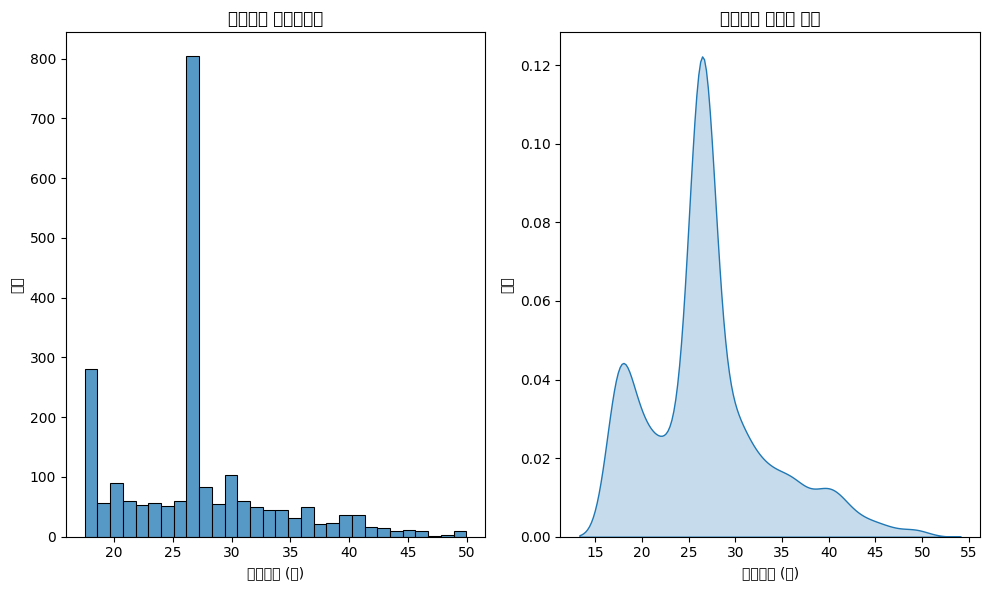

In [36]:
# 전용면적에 대한 히스토그램 및 덴시티 플롯
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 2)
sns.kdeplot(train['전용면적'], shade=True)
plt.title('전용면적 덴시티 플롯')
plt.xlabel('전용면적 (㎡)')
plt.ylabel('밀도')

plt.subplot(1, 2, 1)
sns.histplot(train['전용면적'], bins=30, kde=False)
plt.title('전용면적 히스토그램')
plt.xlabel('전용면적 (㎡)')
plt.ylabel('빈도')

plt.tight_layout()
plt.show()

In [37]:
bins = [0, 10, 20, 30, 40, 50]
labels = ['작은 면적', '중간 면적', '큰 면적', '아주 큰 면적', '거대한 면적']
train['전용면적_구간'] = pd.cut(train['전용면적'], bins=bins, labels=labels)

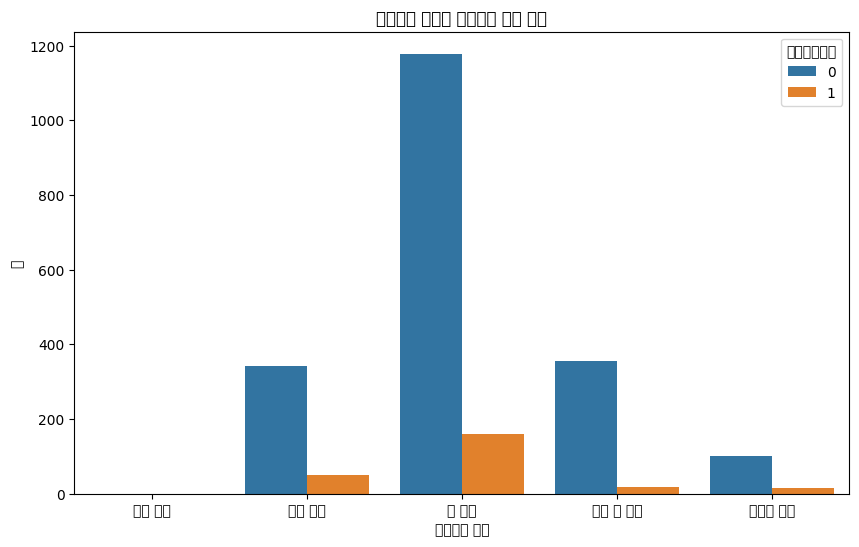

In [38]:
plt.figure(figsize=(10, 6))

# 막대 그래프
sns.countplot(x='전용면적_구간', hue='허위매물여부', data=train)
plt.title('전용면적 구간별 허위매물 여부 분포')
plt.xlabel('전용면적 구간')
plt.ylabel('수')
plt.show()

In [39]:
# 전용면적 구간별 허위매물 여부의 비율 계산
허위매물_비율 = train.groupby('전용면적_구간')['허위매물여부'].mean()

# 결과 출력
허위매물_비율

,허위매물여부
전용면적_구간,
작은 면적,NaN
중간 면적,0.129442
큰 면적,0.120239
아주 큰 면적,0.050667
거대한 면적,0.121739


2-1. 허위매물간의 관계

<Figure size 1200x600 with 0 Axes>

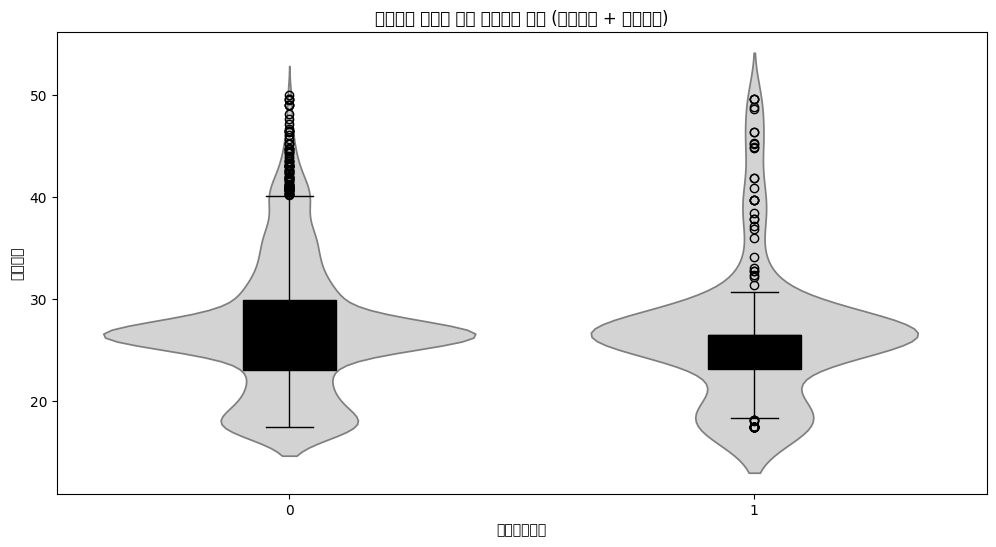

In [40]:
# 바이올린 플롯을 사용하여 허위매물 여부에 따른 전용면적 분포를 시각화
plt.figure(figsize=(12, 6))

# 바이올린 플롯과 박스플롯을 합쳐서 시각화
plt.figure(figsize=(12, 6))
sns.violinplot(data=train, x='허위매물여부', y='전용면적', inner=None, color='lightgray')  # 바이올린 플롯
sns.boxplot(data=train, x='허위매물여부', y='전용면적', width=0.2, color='black')  # 박스플롯
plt.title('허위매물 여부에 따른 전용면적 분포 (바이올린 + 박스플롯)')
plt.xlabel('허위매물여부')
plt.ylabel('전용면적')
plt.show()

## 해당층

In [41]:
# 해당층이 0 이하인 값 확인
invalid_floor = train[train['해당층'] <= 0]
print(f"해당층이 0 이하인 값: {len(invalid_floor)}개")

해당층이 0 이하인 값: 0개


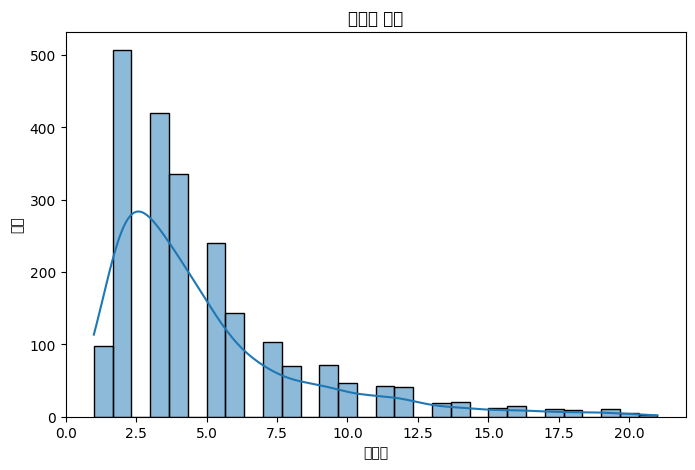

In [42]:
# 해당층의 분포 시각화 (히스토그램)
plt.figure(figsize=(8, 5))
sns.histplot(train['해당층'], bins=30, kde=True)
plt.title('해당층 분포')
plt.xlabel('해당층')
plt.ylabel('빈도')
plt.show()

## 총층

In [43]:
correlation = train['총층'].corr(train['허위매물여부'])
print(f"총층과 허위매물여부 간의 상관계수: {correlation}")

총층과 허위매물여부 간의 상관계수: -0.1494489815253819


#### 해당층과 총층 파생변수 생성
- 해당층/총층 으로 매물이 건물 내에서 어느 정도의 높이에 위치하는지를 나타낼 수 있음

In [44]:
train['층비율'] = train['해당층'] / train['총층']
train['층구분'] = train['층비율'].apply(lambda x: '고층' if x > 0.5 else '저층')
train[['해당층', '총층', '층비율', '층구분']].head()

,해당층,총층,층비율,층구분
1,3.0,4.0,0.750000,고층
2,2.0,3.0,0.666667,고층
3,3.0,9.0,0.333333,저층
4,3.0,3.0,1.000000,고층
6,2.0,3.0,0.666667,고층


In [45]:
test['층비율'] = test['해당층'] / test['총층']
test['층구분'] = test['층비율'].apply(lambda x: '고층' if x > 0.5 else '저층')
test[['해당층', '총층', '층비율', '층구분']].head()

,해당층,총층,층비율,층구분
0,5.0,5.0,1.000000,고층
1,7.0,11.0,0.636364,고층
2,2.0,3.0,0.666667,고층
3,5.0,6.0,0.833333,고층
4,2.0,3.0,0.666667,고층


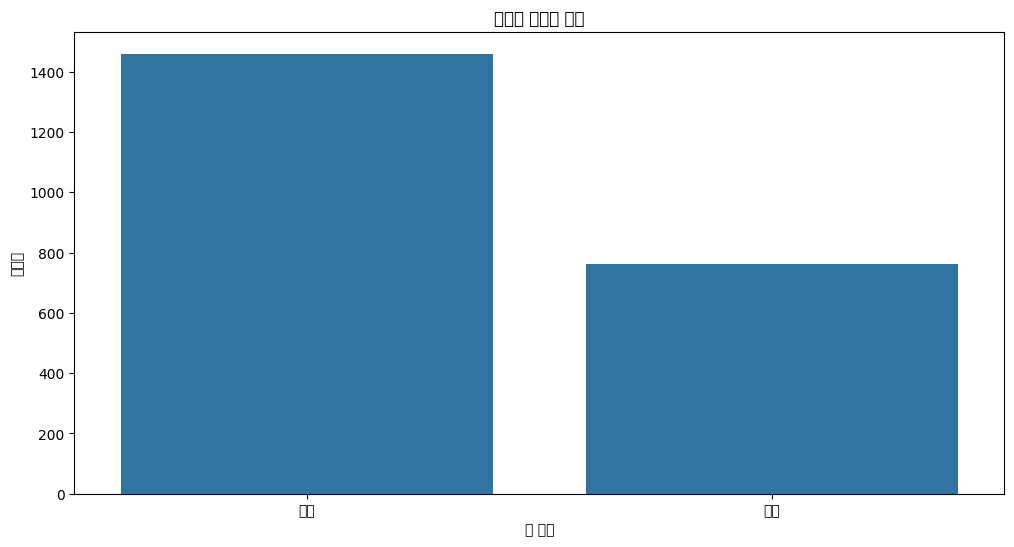

In [46]:
plt.figure(figsize=(12, 6))

sns.countplot(data=train, x='층구분', dodge=False)

plt.title('고층과 저층의 비율')
plt.xlabel('층 구분')
plt.ylabel('빈도수')

plt.show()

In [47]:
# '해당층'과 '총층' 변수 삭제
train = train.drop(columns=["해당층", "총층","층비율","ID","전용면적_구간","월세_boxcox","보증금_boxcox"], errors="ignore")
test = test.drop(columns=["해당층", "총층","층비율","ID","전용면적_구간","월세_boxcox","보증금_boxcox"], errors="ignore")

print("train 데이터 컬럼:", train.columns)
print("test 데이터 컬럼:", test.columns)

train 데이터 컬럼: Index(['매물확인방식', '보증금', '월세', '전용면적', '방수', '욕실수', '주차가능여부', '총주차대수', '관리비',
       '중개사무소', '제공플랫폼', '게재일', '허위매물여부', '게재일_연도', '게재일_월', '방향_남동향',
       '방향_남서향', '방향_남향', '방향_동향', '방향_북동향', '방향_북서향', '방향_북향', '방향_서향',
       '층구분'],
      dtype='object')
test 데이터 컬럼: Index(['매물확인방식', '보증금', '월세', '전용면적', '방수', '욕실수', '주차가능여부', '총주차대수', '관리비',
       '중개사무소', '제공플랫폼', '게재일', '게재일_연도', '게재일_월', '방향_남동향', '방향_남서향', '방향_남향',
       '방향_동향', '방향_북동향', '방향_북서향', '방향_북향', '방향_서향', '층구분'],
      dtype='object')


In [48]:
# train 데이터 전체 결측치 개수 확인
total_missing = train.isnull().sum().sum()
print("train 데이터의 전체 결측치 개수:", total_missing)

train 데이터의 전체 결측치 개수: 0


# Scaling

## StandardScaler 적용

# **인코딩**

In [49]:
train_encoded = train.copy()
test_encoded = test.copy()

In [50]:
# One-Hot Encoding 적용할 컬럼 지정 (필요한 컬럼만 선택 가능)
onehot_cols = ["매물확인방식", "주차가능여부", "층구분", "중개사무소", "제공플랫폼"]

# One-Hot Encoding 실행 (자동 적용)
train_onehot = pd.get_dummies(train, columns=onehot_cols, dtype=int, drop_first=False)

# 변환된 데이터 확인
print("\n🔹 변환된 One-Hot Encoding 데이터:")
print(train_onehot.head())

# 변환된 데이터 저장 (선택 사항)
train_onehot.to_csv("train_onehot_fixed.csv", index=False, encoding="utf-8")
print("\n One-Hot Encoding 완료! 'train_onehot_fixed.csv' 파일 저장됨.")


🔹 변환된 One-Hot Encoding 데이터:
           보증금      월세   전용면적   방수  욕실수  총주차대수  관리비        게재일  허위매물여부  \
1  170500000.0  200000  26.44  2.0  1.0    0.0    0 2024-12-26       0   
2  114000000.0  380000  26.44  1.0  1.0    0.0    0 2024-11-28       0   
3  163500000.0   30000  36.30  2.0  1.0   13.0   10 2024-11-26       0   
4  346000000.0  530000  26.44  2.0  1.0    0.0    0 2024-06-25       1   
6  348500000.0  400000  26.44  1.0  1.0    0.0    0 2024-08-23       0   

   게재일_연도  ...  제공플랫폼_D플랫폼  제공플랫폼_E플랫폼  제공플랫폼_F플랫폼  제공플랫폼_G플랫폼  제공플랫폼_H플랫폼  \
1    2024  ...           1           0           0           0           0   
2    2024  ...           0           0           0           0           0   
3    2024  ...           0           0           0           0           0   
4    2024  ...           0           0           0           0           0   
6    2024  ...           1           0           0           0           0   

   제공플랫폼_I플랫폼  제공플랫폼_J플랫폼  제공플랫폼_K플랫폼  제공플랫폼_L플랫폼  제공플랫폼_

In [51]:
# One-Hot Encoding 적용할 컬럼 지정
onehot_cols = ["매물확인방식", "주차가능여부", "층구분", "중개사무소","제공플랫폼"]

# test 데이터에도 train과 동일한 One-Hot Encoding 적용
test_onehot = pd.get_dummies(test, columns=onehot_cols, dtype=int, drop_first=False)

# train에서 생성된 컬럼이 test에도 동일하게 존재하도록 맞추기 (누락된 컬럼 처리)
for col in train_onehot.columns:
    if col not in test_onehot.columns:
        test_onehot[col] = 0  # test에 없는 컬럼은 0으로 채움

# 컬럼 순서 맞추기 (train과 test 동일한 컬럼 순서 유지)
test_onehot = test_onehot[train_onehot.columns]

# 변환된 데이터 확인
print("\n🔹 변환된 One-Hot Encoding 데이터 (Test):")
print(test_onehot.head())

# 변환된 데이터 저장 (선택 사항)
test_onehot.to_csv("test_onehot_fixed.csv", index=False, encoding="utf-8")
print("\n One-Hot Encoding 완료! 'train_onehot_fixed.csv', 'test_onehot_fixed.csv' 파일 저장됨.")



🔹 변환된 One-Hot Encoding 데이터 (Test):
           보증금      월세   전용면적   방수  욕실수      총주차대수  관리비        게재일  허위매물여부  \
0  223000000.0  530000    NaN  1.0  1.0   0.000000    7 2024-10-21       0   
1  150500000.0  590000  30.26  1.0  1.0  16.000000   11 2023-09-02       0   
2   47000000.0  200000  41.50  2.0  1.0   0.000000    0 2024-04-03       0   
3  133000000.0  250000  31.35  2.0  1.0  20.702509    5 2024-09-19       0   
4  108000000.0  380000  23.14  1.0  1.0   0.000000    0 2024-11-10       0   

   게재일_연도  ...  제공플랫폼_D플랫폼  제공플랫폼_E플랫폼  제공플랫폼_F플랫폼  제공플랫폼_G플랫폼  제공플랫폼_H플랫폼  \
0    2024  ...           1           0           0           0           0   
1    2023  ...           1           0           0           0           0   
2    2024  ...           0           0           0           0           0   
3    2024  ...           0           0           0           0           0   
4    2024  ...           0           0           0           0           0   

   제공플랫폼_I플랫폼  제공플랫폼_J플랫폼 

In [52]:
print("\n 원본 데이터 크기:", train_onehot.shape)


 원본 데이터 크기: (2223, 302)


In [53]:
print("\n 원본 데이터 크기:", test_onehot.shape)


 원본 데이터 크기: (613, 302)


In [54]:
train_final = train_onehot

# 최종 데이터 저장
train_final.to_csv("train_final.csv", index=False, encoding="utf-8")

print("\n 최종 파일 'train_final.csv' 생성 완료! (One-Hot Encoding 포함)")


 최종 파일 'train_final.csv' 생성 완료! (One-Hot Encoding 포함)


In [55]:
# test 데이터에서도 One-Hot Encoding + Label Encoding 결합
test_final = test_onehot

# 최종 데이터 저장 (test_final.csv 생성)
test_final.to_csv("test_final.csv", index=False, encoding="utf-8")

print("\n 최종 파일 'test_final.csv' 생성 완료! (One-Hot 포함)")



 최종 파일 'test_final.csv' 생성 완료! (One-Hot 포함)


In [56]:
train_final = train_final.drop(['게재일'], axis=1)

In [57]:
train_final.columns

Index(['보증금', '월세', '전용면적', '방수', '욕실수', '총주차대수', '관리비', '허위매물여부', '게재일_연도',
       '게재일_월',
       ...
       '제공플랫폼_D플랫폼', '제공플랫폼_E플랫폼', '제공플랫폼_F플랫폼', '제공플랫폼_G플랫폼', '제공플랫폼_H플랫폼',
       '제공플랫폼_I플랫폼', '제공플랫폼_J플랫폼', '제공플랫폼_K플랫폼', '제공플랫폼_L플랫폼', '제공플랫폼_M플랫폼'],
      dtype='object', length=301)

In [58]:
test_final = test_final.drop(['허위매물여부', '게재일'], axis=1)

In [59]:
test_final.columns

Index(['보증금', '월세', '전용면적', '방수', '욕실수', '총주차대수', '관리비', '게재일_연도', '게재일_월',
       '방향_남동향',
       ...
       '제공플랫폼_D플랫폼', '제공플랫폼_E플랫폼', '제공플랫폼_F플랫폼', '제공플랫폼_G플랫폼', '제공플랫폼_H플랫폼',
       '제공플랫폼_I플랫폼', '제공플랫폼_J플랫폼', '제공플랫폼_K플랫폼', '제공플랫폼_L플랫폼', '제공플랫폼_M플랫폼'],
      dtype='object', length=300)

# 학습 데이터 분리

In [60]:
# 피처와 타겟 데이터 분리
X = train_final.drop(["허위매물여부"], axis = 1)
y= train_final["허위매물여부"].astype(int)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 모델 선택 및 훈련

In [61]:
!pip uninstall -y catboost
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.6 MB/s eta 0:00:00


In [62]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier,
    GradientBoostingClassifier, HistGradientBoostingClassifier, BaggingClassifier
)
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

# 추가된 모델들
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# 🔹 랜덤 시드 및 KFold 설정
random_state = 42
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

# 🔹 분류 모델 리스트 (추가된 모델 포함)
classifiers = [
    SVC(probability=True, random_state=random_state),
    DecisionTreeClassifier(random_state=random_state),
    AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1),
    RandomForestClassifier(random_state=random_state),
    ExtraTreesClassifier(random_state=random_state),
    GradientBoostingClassifier(random_state=random_state),
    HistGradientBoostingClassifier(random_state=random_state),
    BaggingClassifier(random_state=random_state),
    XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=random_state),
    LGBMClassifier(random_state=random_state),
    CatBoostClassifier(verbose=0, random_state=random_state),
    MLPClassifier(random_state=random_state),
    KNeighborsClassifier(),
    LogisticRegression(random_state=random_state),
    LinearDiscriminantAnalysis()
]

# 🔹 교차 검증 (macro F1 score 사용)
cv_results = []
for classifier in classifiers:
    cv_scores = cross_val_score(
        classifier,
        X_train,
        y_train,
        scoring="f1_macro",
        cv=kfold,
    )
    cv_results.append(cv_scores)

# 🔹 F1 매크로 스코어 평균 및 표준편차 계산
cv_means = [scores.mean() for scores in cv_results]
cv_std = [scores.std() for scores in cv_results]

# 🔹 결과 저장 DataFrame
cv_res = pd.DataFrame({
    "CrossValMeans": cv_means,
    "CrossValErrors": cv_std,
    "Algorithm": [
        "SVC", "DecisionTree", "AdaBoost", "RandomForest", "ExtraTrees",
        "GradientBoosting", "HistGradientBoosting", "Bagging", "XGBoost",
        "LightGBM", "CatBoost", "MultipleLayerPerceptron", "KNeighboors",
        "LogisticRegression", "LinearDiscriminantAnalysis"
    ]
})

# 🔹 평균 F1 점수를 기준으로 정렬 (내림차순)
cv_res_sorted = cv_res.sort_values(by="CrossValMeans", ascending=False).reset_index(drop=True)

# 🔹 최종 결과 출력
print(cv_res_sorted[["Algorithm", "CrossValMeans"]])

[LightGBM] [Info] Number of positive: 157, number of negative: 1265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 734
[LightGBM] [Info] Number of data points in the train set: 1422, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.110408 -> initscore=-2.086582
[LightGBM] [Info] Start training from score -2.086582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 157, number of negative: 1265
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_row_wise=true` to remove the ov

# **HistGradientBoosting**

*히스토그램 기반 그래디언트 부스팅 트리*

- 앙상블 학습 방법 중 하나로, 여러 개의 결정 트리를 조합하여 예측 모델을 구축하는 알고리즘
 - 트리 기반의 모델인 그래디언트 부스팅 트리를 기반으로 함
- 데이터를 '히스토그램으로 변환' 하여 학습 및 예측에 활용하는 점이 특징

**하이퍼 파라미터 튜닝**

StratifiedKFold 사용, X_train, y_train으로 fitting

In [64]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

hist_gb = HistGradientBoostingClassifier(random_state=42)

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_iter' : [50, 100, 300],
    'max_depth': [3, 5, 7, None],
    'min_samples_leaf': [20, 30, 50],
    'max_bins': [50, 100, 255],
    'l2_regularization' : [0, 1]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 약 1시간 소요
grid_search = GridSearchCV(estimator = hist_gb, param_grid = param_grid,
                           scoring = 'accuracy', cv=cv, n_jobs=-1)


grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

Best Parameters: {'l2_regularization': 0, 'learning_rate': 0.1, 'max_bins': 100, 'max_depth': 5, 'max_iter': 300, 'min_samples_leaf': 20}
Best CV Accuracy: 0.9735670200981168


**최적의 모델 학습 및 Prediction**

In [65]:
hist_gb = HistGradientBoostingClassifier(l2_regularization = 0, learning_rate = 0.1, max_bins = 100,
                                         max_depth = 5, max_iter = 300, min_samples_leaf = 20)
hist_gb.fit(X, y)

HistGradientBoostingClassifier(l2_regularization=0, max_bins=100, max_depth=5,
                               max_iter=300)

In [66]:
# test 데이터에서 전용면적의 NaN 값이 처리가 안되어있음
# train의 median값으로 채움 : Data Leaking 방지

test['전용면적'] = test['전용면적'].fillna(train['전용면적'].median())

In [67]:
# 인코딩까지 완료된 test 데이터 : test_final
pred_hist_gb = hist_gb.predict(test_final)

# catboost

In [68]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 기본 모델 설정 (silent=True로 콘솔 출력 최소화)
cat_model = CatBoostClassifier(random_state=42, verbose=0)

# 하이퍼파라미터 후보
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [3, 5, 7],
    'iterations': [100, 300, 500],
    'l2_leaf_reg': [1, 3, 5, 7]
}

# GridSearchCV 설정
grid_cv = GridSearchCV(
    estimator=cat_model,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# 모델 학습
grid_cv.fit(X_train, y_train)

# 최적 결과 출력
print(f"최적 하이퍼파라미터: {grid_cv.best_params_}")
print(f"최고 검증 정확도: {grid_cv.best_score_:.4f}")

# 최적 모델로 예측
cat = grid_cv.best_estimator_
y_pred = cat.predict(X_val)

# 평가 출력
print("\n검증 데이터 성능 평가:")
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

Fitting 3 folds for each of 108 candidates, totalling 324 fits
최적 하이퍼파라미터: {'depth': 7, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
최고 검증 정확도: 0.9640

검증 데이터 성능 평가:
Accuracy: 0.9662921348314607
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       396
           1       0.95      0.73      0.83        49

    accuracy                           0.97       445
   macro avg       0.96      0.86      0.90       445
weighted avg       0.97      0.97      0.96       445



# **GradientBoosting**

In [69]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score

In [70]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid,
                    cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
Best CV Accuracy: 0.965128976103814


In [81]:
gb = grid.best_estimator_
gb.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [82]:
# test 데이터에서 전용면적의 NaN 값이 처리가 안되어있음
# train의 median값으로 채움 : Data Leaking 방지

test_final['전용면적'] = test_final['전용면적'].fillna(train['전용면적'].median())

In [83]:
test_pred = gb.predict(test_final)

In [84]:
submission['허위매물여부'] = test_pred
submission.to_csv('submission_gb.csv', index=False)

In [85]:
from sklearn.metrics import accuracy_score

# 최적의 모델 가져오기
gb = grid.best_estimator_

# train 데이터에 대한 예측
y_pred = gb.predict(X_train)

# 정확도 계산
accuracy = accuracy_score(y_train, y_pred)
print(f"Train Accuracy (Best Model): {accuracy:.4f}")


Train Accuracy (Best Model): 0.9994


# lightgbm

In [76]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import lightgbm as lgb

lgb = lgb.LGBMClassifier(random_state=42)

param_grid = {
    'num_leaves': [31, 63],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
    'max_depth': [-1, 3, 5],         # -1은 제한 없음, 혹은 [3, 5, 7] 등으로 설정
    'min_child_samples': [20, 50, 100]
}


grid_cv = GridSearchCV(
    estimator=lgb,
    param_grid=param_grid,
    cv=3,  # 3-Fold 교차검증
    scoring='accuracy',  # 필요시 'f1', 'recall', 'precision' 등으로 변경 가능
    n_jobs=-1,  # 가능한 모든 CPU 코어 사용
    verbose=1
)

grid_cv.fit(X_train, y_train)

print(f"최적 하이퍼파라미터: {grid_cv.best_params_}")
print(f"최고 검증 정확도: {grid_cv.best_score_:.4f}")

lgb = grid_cv.best_estimator_
y_pred = lgb.predict(X_val)

print("\n검증 데이터 성능 평가:")
print("Accuracy:", accuracy_score(y_val, y_pred))

Fitting 3 folds for each of 162 candidates, totalling 486 fits
[LightGBM] [Info] Number of positive: 196, number of negative: 1582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 1778, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.110236 -> initscore=-2.088330
[LightGBM] [Info] Start training from score -2.088330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

# **XGBoost**

In [78]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.05],
    'n_estimators': [100, 300, 500],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9],
    'gamma': [0, 0.1, 0.2]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
                    param_grid, cv=cv, scoring='accuracy', n_jobs=-1, verbose=1)

grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Parameters: {'colsample_bytree': 0.9, 'gamma': 0.2, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.9}
Best CV Accuracy: 0.9724386770058555


In [79]:
# 최적의 하이퍼파라미터로 다시 학습
import xgboost as xgb

xgb = xgb.XGBClassifier(
    colsample_bytree=0.9,
    gamma=0.1,
    learning_rate=0.05,
    max_depth=5,
    n_estimators=300,
    subsample=0.9,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

# 앙상블

In [87]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

# Hard Voting
hard_voting = VotingClassifier(
    estimators=[('xgb', xgb), ('lgb', lgb), ('cat', cat), ('gb', gb), ('hist_gb', hist_gb)],
    voting='hard'
)
hard_voting.fit(X_train, y_train)
y_pred_hard = hard_voting.predict(X_val)
print("Hard Voting Accuracy:", accuracy_score(y_val, y_pred_hard))


# Soft Voting
soft_voting = VotingClassifier(
    estimators=[('xgb', xgb), ('lgb', lgb), ('cat', cat), ('gb', gb), ('hist_gb', hist_gb)],
    voting='soft'
)
soft_voting.fit(X_train, y_train)
y_pred_soft = soft_voting.predict(X_val)
print("Soft Voting Accuracy:", accuracy_score(y_val, y_pred_soft))

# Stacking (메타 모델: 로지스틱 회귀)
stacking = StackingClassifier(
    estimators=[('xgb', xgb), ('lgb', lgb), ('cat', cat), ('gb', gb), ('hist_gb', hist_gb)],
    final_estimator=LogisticRegression(),
    stack_method='auto'
)
stacking.fit(X_train, y_train)
y_pred_stack = stacking.predict(X_val)
print("Stacking Accuracy:", accuracy_score(y_val, y_pred_stack))

[LightGBM] [Info] Number of positive: 196, number of negative: 1582
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 727
[LightGBM] [Info] Number of data points in the train set: 1778, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.110236 -> initscore=-2.088330
[LightGBM] [Info] Start training from score -2.088330
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [97]:
# sample_submission 불러오기
submission = pd.read_csv('sample_submission.csv')

# 예측값으로 대체
submission['허위매물여부'] = stacking.predict(test_final)

# 저장
submission.to_csv('submission_stacking.csv', index=False)

print("제출 파일이 저장되었습니다: submission_stacking.csv")

제출 파일이 저장되었습니다: submission_stacking.csv
